Spectroscopic data reduction... now using rascal. 

In [1]:
# start by importing the essentials 
import numpy as np 
from astropy.io import fits 
from astropy import units as u 
from astropy.io import ascii
from astropy.table import Table

from matplotlib import pyplot as plt 

from scipy.signal import find_peaks

from rascal.calibrator import Calibrator
from rascal.atlas import Atlas
from rascal.util import refine_peaks
from rascal import models

/opt/anaconda3/envs/astr230/lib/python3.12/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# (0) read in the data

### Arc Lamps: 

In [2]:
# a long exposure He lamp
he_i_long = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/he_i_lowres_long.fits')

# a short exposure Ne/Ar lamp
ne_i_short = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/ne_i_lowres_short.fits') 
# a long exposure Ne/Ar lamp
ne_i_long = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/ne_i_lowres_long.fits') 

### Flats and Biases: 

In [3]:
# a flat field for the spectra
flat = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/specflat.fits')

# a bias image with exposure time zero
bias = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/specbias.fits')

### Science Targets: 

In [4]:
# Castor - a bright binary star with both components acquired
castor = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/castor.fits')

# Beta CMi - a star with an interesting spectrum
betacmi = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/betacmi.fits') 

### Flux calibrator: 

In [5]:
# Regulus is a spectral standard star with a known spectral energy distribution
regulus = fits.open('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/regulus.fits')

# (1) Trim and subtract bias from all the data. 

Except for setting the dispersion direction, these steps are the same as you do for an image. To start, display the long lamp spectrum of Ne/Ar. 

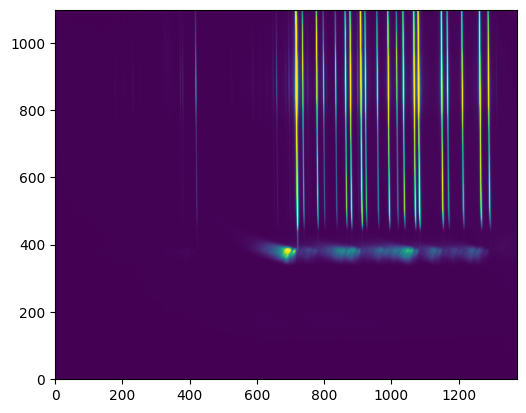

In [6]:
plt.imshow(ne_i_long[0].data, origin='lower')

The vertical lines are emission lines. These trace how wavelengths map to pixel space on the detector. Notice that they disappear at the bottom; this marks the bottom of the slit. We’re only interested in the vertical region where lines are well-recorded. Decide on the range of y-values that you want to keep (keep all the x-values for now). 

In [7]:
# trim the images 
# lamps
lab2t_ne_long = ne_i_long[0].data[450:-10,:]
lab2t_ne_short = ne_i_short[0].data[450:-10,:]
lab2t_he_long = he_i_long[0].data[450:-10,:]

# flat 
lab2t_flat = flat[0].data[450:-10,:]

# regulus
lab2t_regulus = regulus[0].data[450:-10,:]

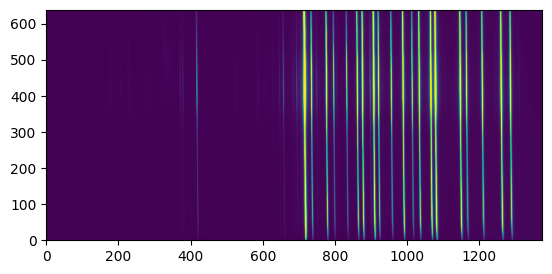

In [8]:
plt.imshow(lab2t_ne_long, origin='lower')

Trim all the lamps, the bias, the flat, the objects, and the flux calibrator in this way. All the images need to be trimmed in the same way.

Now subtract the bias:

In [9]:
lab2t_ne_long.shape

(639, 1374)

In [10]:
# lamps 
lab2tb_ne_long = lab2t_ne_long - bias[0].data[450:-10,:]
lab2tb_ne_short = lab2t_ne_short - bias[0].data[450:-10,:]
lab2tb_he_long = lab2t_he_long - bias[0].data[450:-10,:]

# regulus
lab2tb_regulus = lab2t_regulus - bias[0].data[450:-10,:]

Note how we chose a name of the variable to indicate that these data have been trimmed and bias subtracted. 

## (1.5) Subtract the dark current. 

Normally we’d want to take a dark frame with the same exposure time as the target and subtract that. But these stars are all really bright and the exposure times are short so there is effectively no dark. So for this lab, we'll just subtract the trimmed bias frame.

# (2) Flatfield the data to correct for pixel-to-pixel variations. 

To get a feel for what a flatfield image is and what it will do to our data, first display the flatfield. 

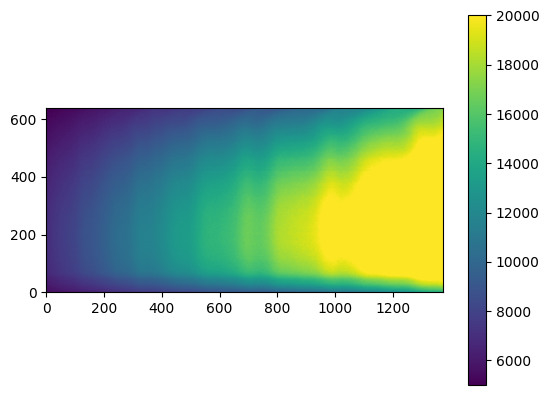

In [11]:
plt.imshow(lab2t_flat, origin='lower', vmin=5000, vmax=20000)
plt.colorbar()

Notice how much structure there is in the image (it's not very 'flat'). This is a measure of how the system illuminates the CCD. We want to correct for this uneven response. To do this, we first want to normalize the flat so that its average value is ~1. 

In [12]:
norm_flat = lab2t_flat / np.median(lab2t_flat)
np.median(norm_flat)

1.0

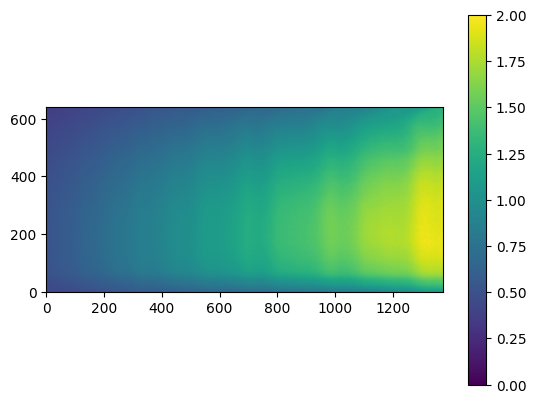

In [13]:
plt.imshow(norm_flat, origin='lower', vmin=0, vmax=2)
plt.colorbar()

Now simply divide all three target spectra this flat image. Be sure to give your flatfielded image a name that indicates that this step has been done. 

In [14]:
lab2f_regulus = lab2tb_regulus / norm_flat

### (3) Construct a comparison lamp image from separate He and Ne lamps for wavelength calibration.

Display the short and long Ne lamps, and the long He lamp either with python or in ds9. We have two lamps here, the internal neon lamp which came with the instrument and a helium lamp that we have to hold up to the spectrograph when it is off the telescope. Fortunately, the neon lamp is contaminated with argon, so we get argon lines in the neon lamp (if only we had helium in there as well...). The Ne/Ar lamp has a lot of bright lines in the red half (right side) of the spectrum and fainter lines in most of the left side. The last 15% or so on the far left appears to be blank.

Good wavelength calibrations require that we have lines we can identify across the entire spectral range. To achieve this we need a long exposure so we get enough counts for the fainter Ne/Ar lines but this will cause bright lines to saturate (they have fluxes >65,000 and are flat-topped). Bright lines won’t saturate in a short exposure, but then the faint lines are too noisy to use.

To solve this issue, we’d like to add together the pieces we want from each of the lamp spectra. 

A minor annoyance is that the long Ne lamp had some scattered light that the bias subtraction didn’t remove. Display 'lab2tb_long' and look at the values at a place where there is no line emission. The first step is to subtract out that constant to make the inter-line regions near zero.

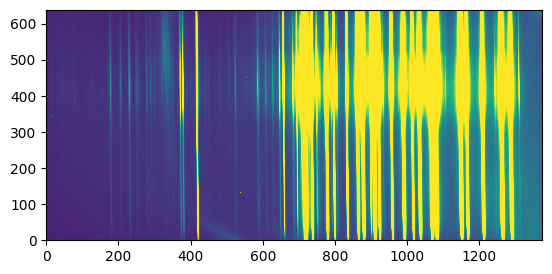

In [15]:
plt.imshow(lab2tb_ne_long, origin='lower', vmin=0, vmax=2500)

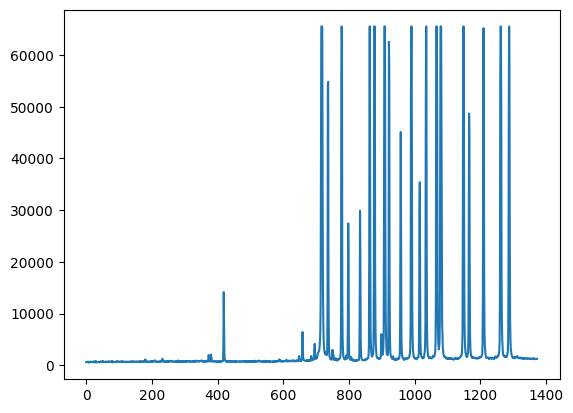

In [16]:
# take a slice across the image to look at the background level 
plt.plot(lab2t_ne_long[200,:])

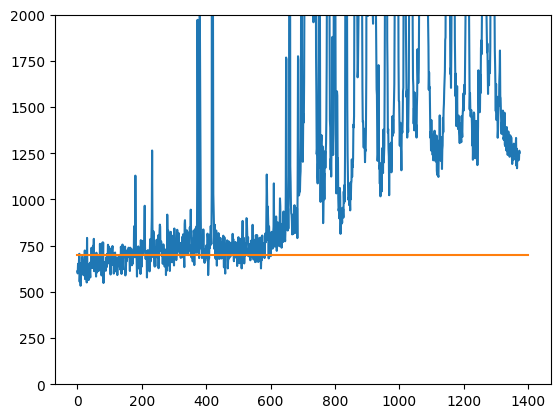

In [17]:
# zooming in to find the inter-line region and estimate the constant to subtract 
plt.plot(lab2t_ne_long[200,:])
plt.ylim([0,2000])
plt.plot([0,1400],[700,700])

In [18]:
ne_constant = 700.

In [19]:
# subtract this constant from the lamp 
lamp_spec = lab2t_ne_long - ne_constant

Now we need to identify the portion of the spectrum where the lines are saturated (which we don't want) and where the lines are useable. We will substitute the short exposure where the lines in the long exposure are saturated. Let's stitch together the two exposures. 

In [20]:
lamp_spec[:,700:] = lab2tb_ne_short[:,700:]

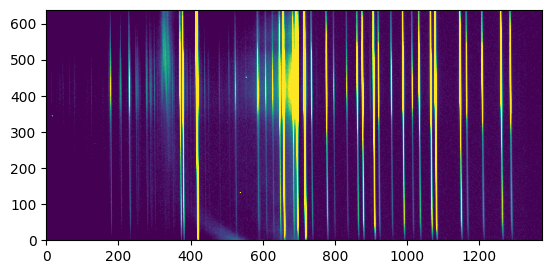

In [21]:
# take a look at the stitched together lamp file 
plt.imshow(lamp_spec, origin='lower', vmin=0, vmax=1000)

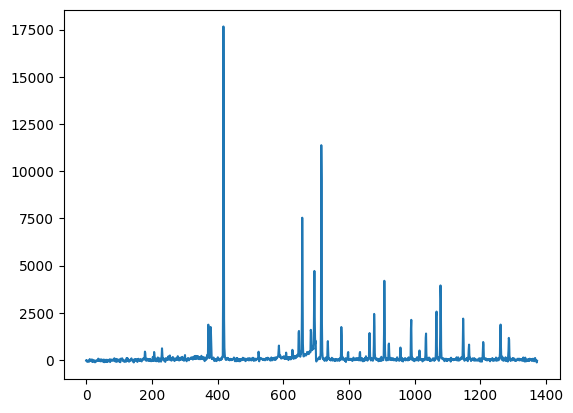

In [22]:
plt.plot(lamp_spec[300,:])

Notice that the join isn't perfectly smooth. The background level in the composite doesn’t need to match perfectly because we are primarily interested in the location of the emission lines, but you don’t want it to be highly discontinuous where the frames are spliced together. 

We still have almost no lines in the bluest portion of the spectrum (far left). That is why we took the helium lamp. You’ll notice He
has several lines there (as well as two really bright ones in the red but we don’t need those). We’d like to just add the useful blue part to our composite lamp spectrum.

First, check to make sure the area between the lines in the long He lamp has approximately zero counts.

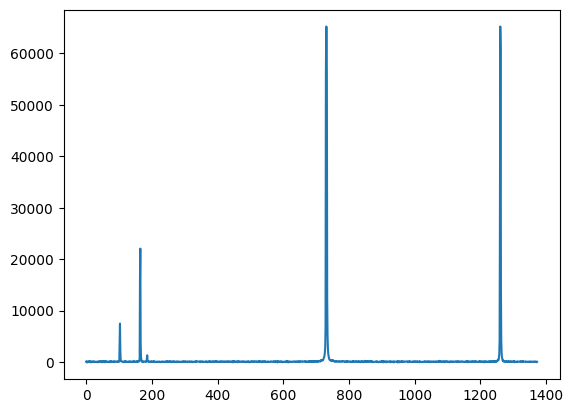

In [23]:
plt.plot(lab2tb_he_long[300,:])

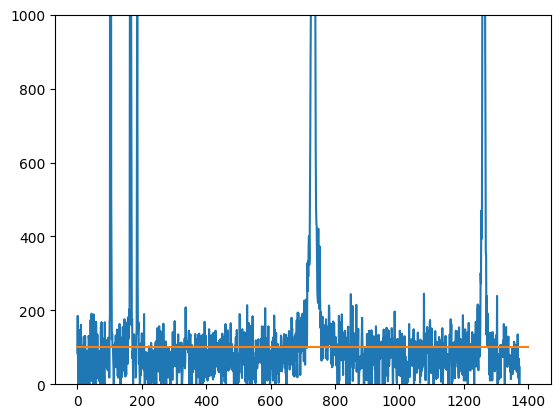

In [24]:
# zoom in to see how close to zero...
plt.plot(lab2tb_he_long[300,:])
plt.ylim([0,1000])
plt.plot([0,1400],[100,100])

Now we want to keep only the blue lines and set the rest of the array to zero so we can add the He lines to our composite spectrum.

In [25]:
# make a new array so we don't have to start over if we make a mistake 
blue_he_lines = lab2t_he_long - 200. 
# subtracting off a constant so the inter-line region is almost zero. 

In [26]:
# then set the red side of the array to zero
blue_he_lines[:,400:] = 0.

This should give us an image that is exactly or nearly zero everywhere except where there are the lines in the blue. Check to be sure this looks okay before adding it to the composite lamp spectrum. 

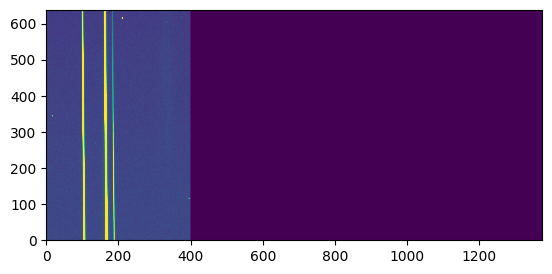

In [27]:
plt.imshow(blue_he_lines, origin='lower', vmin=0, vmax=1000)

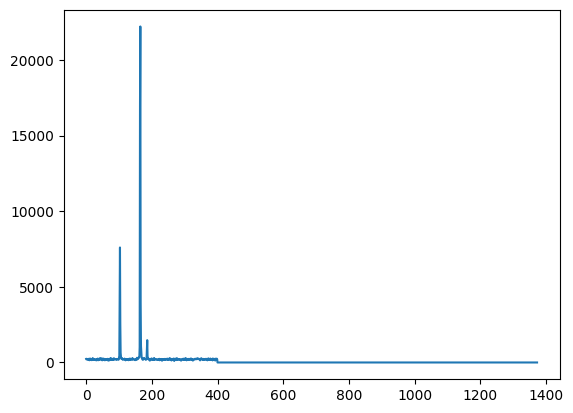

In [28]:
plt.plot(blue_he_lines[300,:])

If everything looks okay, add this to the composite lamp spectrum. 

In [29]:
lamp_spec += blue_he_lines

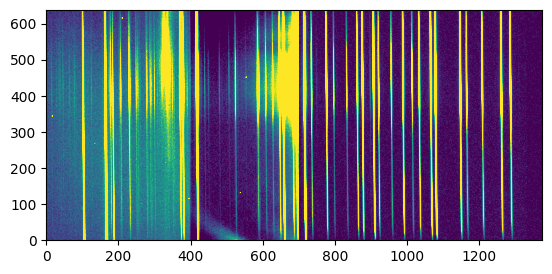

In [30]:
plt.imshow(lamp_spec, origin='lower', vmin=0, vmax=500)

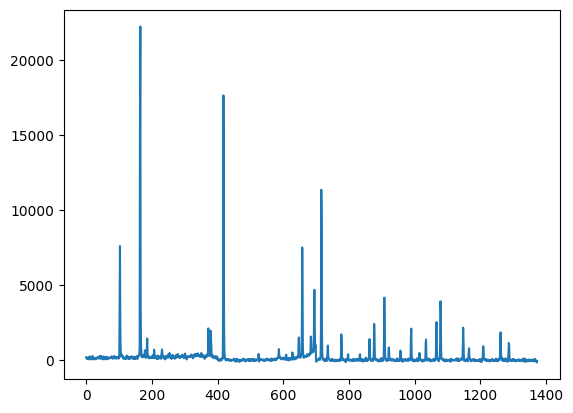

In [31]:
plt.plot(lamp_spec[300,:])

Display your reduced lamp spectra and the composite lamp spectrum in different frames in ds9 and blink through them. The composite lamp spectrum should have a lot of lines but none that are saturated. We will use this composite spectrum for all wavelength calibrations.

In [32]:
fits.writeto('lamp_spec.fits', lamp_spec, overwrite=True)

## use Rascal to do wavelength calibration 

In [33]:
# Get the median along the spectral direction
spectrum = np.median(lamp_spec, axis=0)


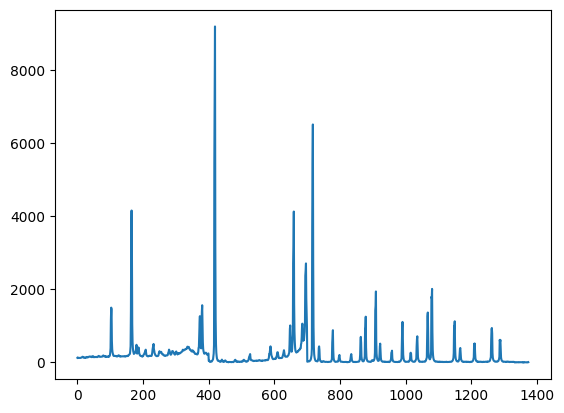

In [34]:
plt.plot(spectrum)

In [35]:
# Get the spectral lines
peaks, _ = find_peaks(spectrum, threshold=8)
peaks_refined = refine_peaks(spectrum,peaks)

/opt/anaconda3/envs/astr230/lib/python3.12/site-packages/rascal/util.py:383: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss, x[mask], y[mask], p0=[1, mean, sigma])


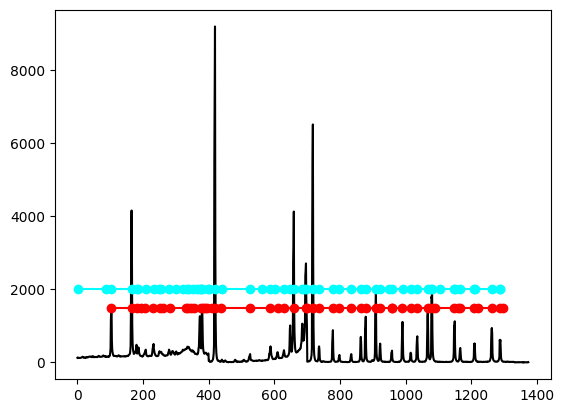

In [36]:
plt.plot(spectrum, color='black')
plt.plot(peaks, np.zeros(peaks.shape)+2000., marker='o', color='cyan')
plt.plot(peaks_refined, np.zeros(peaks_refined.shape)+1500., marker='o', color='red')

(800.0, 1200.0)

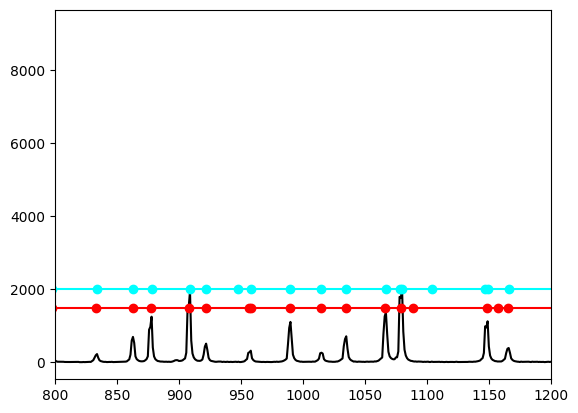

In [37]:
plt.plot(spectrum, color='black')
plt.plot(peaks, np.zeros(peaks.shape)+2000., marker='o', color='cyan')
plt.plot(peaks_refined, np.zeros(peaks_refined.shape)+1500., marker='o', color='red')
plt.xlim([800, 1200])

In [38]:
# Set up the Calibrator object
c = Calibrator(peaks_refined,spectrum)
c.set_calibrator_properties(num_pix=len(spectrum),
                            plotting_library='matplotlib',
                            log_level='info')


[Wed, 03 Apr 2024 09:11:43] INFO [calibrator.py:997] num_pix is set to 1374.
[Wed, 03 Apr 2024 09:11:43] INFO [calibrator.py:1012] pixel_list is set to None.
[Wed, 03 Apr 2024 09:11:43] INFO [calibrator.py:1045] Plotting with matplotlib.


In [39]:
# read in bespoke line list for ASTR lab 

linelist = Table.read('/Users/mr82/teaching/ASTR230_spring2024/lab2/lab2_data/mod_shelyaklowres.dat', format='ascii.basic', 
                     data_start=2, names=['wave', 'line']) 

In [40]:
linelist.pprint()

   wave   line
--------- ----
3948.9789   Ar
4026.1914   He
4044.4179   Ar
 4120.815   He
4158.5907   Ar
4181.8836   Ar
 4190.818   Ar
      ...  ...
7503.8691   Ar
7514.6518   Ar
7535.7739   Ne
7544.0443   Ne
 7635.106   Ar
 7891.075   Ar
7948.1764   Ar
Length = 74 rows


In [41]:
#c.add_user_atlas(linelist['line'], linelist['wave'])#, intensities=None)
c.add_user_atlas(elements=linelist['line'], wavelengths=linelist['wave'], 
           constrain_poly=True)
'''
atlas = Atlas(elements=['Ar','He','Ne'],
              min_intensity=5,
              pressure=80000.0,
              temperature=285.0,
              range_tolerance=500,)
c.set_atlas(atlas)
'''

[Wed, 03 Apr 2024 09:11:43] WARNING [calibrator.py:1493] Using add_user_atlas is now deprecated. Please use the new Atlas class.


"\natlas = Atlas(elements=['Ar','He','Ne'],\n              min_intensity=5,\n              pressure=80000.0,\n              temperature=285.0,\n              range_tolerance=500,)\nc.set_atlas(atlas)\n"

In [42]:
# Solve for the wavelength calibration
best_polyfit_coefficient, rms, residual, peak_utilisation = c.fit()

ValueError: operands could not be broadcast together with shapes (739,2) (0,) 

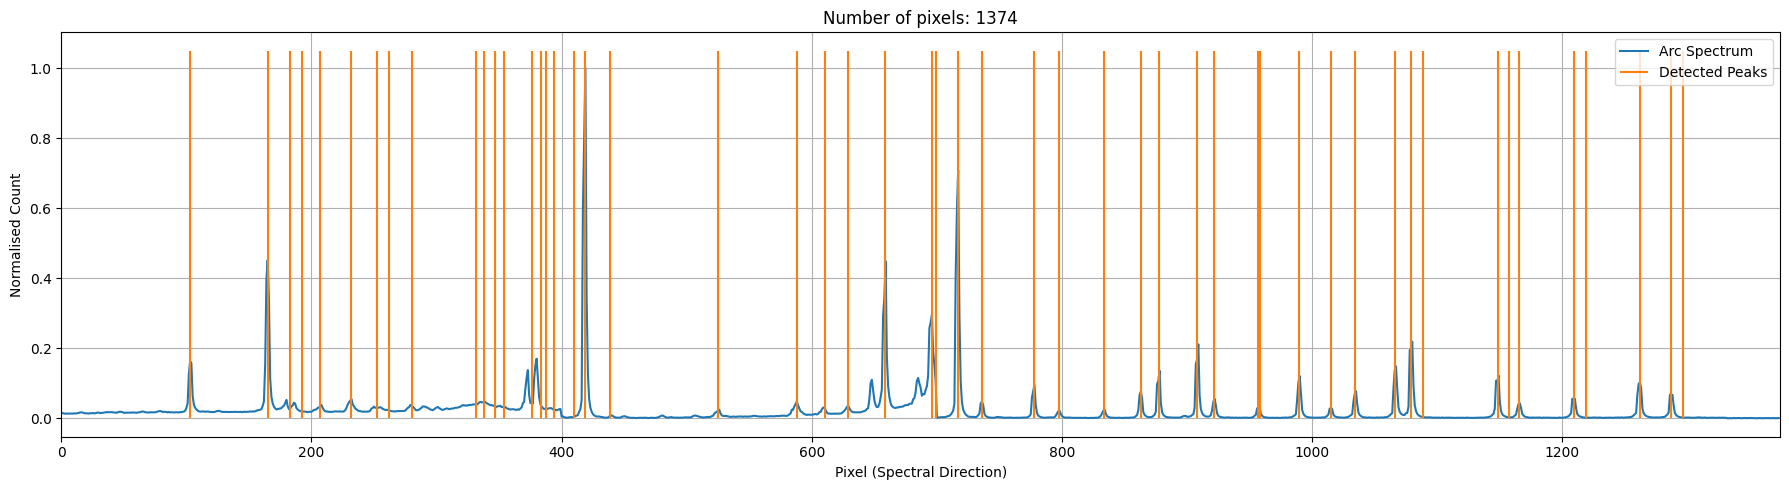

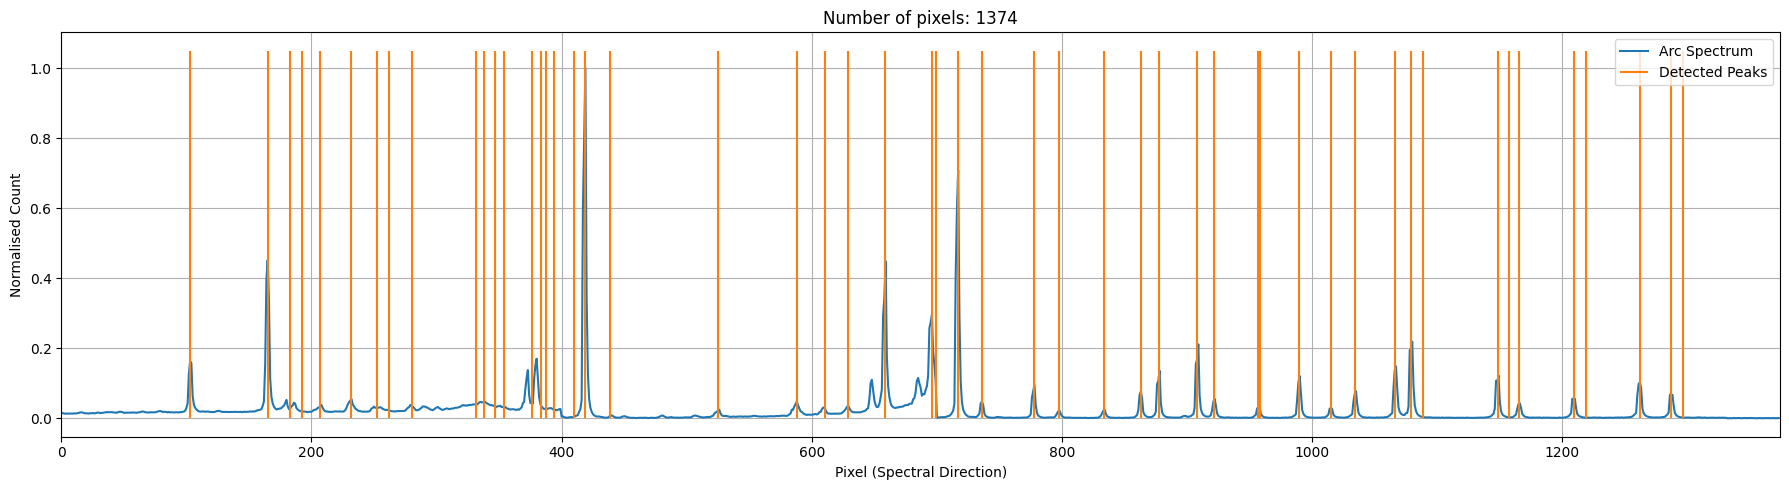

In [43]:
c.plot_arc()

In [44]:
c.set_hough_properties(num_slopes=10000,
                       xbins=1000,
                       ybins=1000,
                       min_wavelength=3500.,
                       max_wavelength=9000.,
                       range_tolerance=500.,
                       linearity_tolerance=50)

c.set_ransac_properties(sample_size=5,
                        top_n_candidate=8)


In [45]:
# try the fit 

c.do_hough_transform()

ValueError: operands could not be broadcast together with shapes (746,2) (0,) 

In [48]:
c.set_known_pairs(pix=[103, 165, 990, 1262, 1287], wave=[4921.889, 5015.6343, 6266.495, 6678.276, 6717.043])

In [49]:
c.do_hough_transform()

ValueError: operands could not be broadcast together with shapes (746,2) (0,) 